In [166]:
import os

proj_dir = '/Users/nickbachelder/Desktop/Kaggle/Linemen'
os.chdir( os.path.join(proj_dir, 'code/objects') )

%run load_modules.ipynb
%run tracking_objects.ipynb

In [167]:
data_dir = os.path.join(proj_dir, 'data' )
os.chdir( proj_dir )
os.system("rm -rf {}".format( data_dir ))
os.system('mkdir data')
os.chdir( data_dir )
os.system("kaggle competitions download -c nfl-big-data-bowl-2023")
os.system( 'unzip {}.zip'.format( os.path.join(data_dir, 'nfl-big-data-bowl-2023')) )

curr_cd = os.getcwd()
files = [x for x in os.listdir(curr_cd) if os.path.isfile(os.path.join(curr_cd, x))]

player_files = [os.path.join(curr_cd, x) for x in files if x.endswith('players.csv')]
player_tracking_files = [os.path.join(curr_cd, x) for x in files if x.startswith('week')]
play_details_files = [os.path.join(curr_cd, x) for x in files if x.endswith('ScoutingData.csv')]
play_info_files = [os.path.join(curr_cd, x) for x in files if x.endswith('plays.csv')]


100%|██████████| 172M/172M [00:13<00:00, 13.4MB/s] 



Archive:  /Users/nickbachelder/Desktop/Kaggle/Linemen/data/nfl-big-data-bowl-2023.zip
  inflating: games.csv               
  inflating: pffScoutingData.csv     
  inflating: players.csv             
  inflating: plays.csv               
  inflating: week1.csv               
  inflating: week2.csv               
  inflating: week3.csv               
  inflating: week4.csv               
  inflating: week5.csv               
  inflating: week6.csv               
  inflating: week7.csv               
  inflating: week8.csv               


In [168]:
all_data = master_track(track_paths = player_tracking_files, 
                            play_info_path = play_info_files[0],
                            play_details_path = play_details_files[0],
                            players_path = player_files[0])

In [169]:
all_data.load_training_data(week = 2)

Getting week 1 training data


100%|██████████| 1172/1172 [05:45<00:00,  3.39it/s]


Done


In [172]:
all_data.get_averages_up_to_week(week = 2)

Getting week 1 average metrics by position and blocker number
Done


In [330]:
all_dat_labels = all_data.get_rush_sequences_labels(week = 2, normalize = True)
training_dat, test_dat = train_test_split(all_dat_labels, test_size = 0.2)

# remove nas (fix these nas being created later)
bad_indexs = []
print('Train NA')
for value in range(len(training_dat)):
    any_na = training_dat[value][0].isnull().values.any()
    if any_na == True:
        bad_indexs.append(value)
        print(value)

for index in sorted(bad_indexs, reverse=True):
    del training_dat[index]


bad_indexs = []
print('Test NA')
for value in range(len(test_dat)):
    any_na = test_dat[value][0].isnull().values.any()
    if any_na == True:
        bad_indexs.append(value)
        print(value)

for index in sorted(bad_indexs, reverse=True):
    del test_dat[index]

print(f'Length train : {len(training_dat)}')
print(f'Length test : {len(test_dat)}')

Getting week 1 normalized training data


100%|██████████| 1172/1172 [00:00<00:00, 3449.28it/s]

Train NA
465
Test NA
188
Length train : 936
Length test : 234


In [338]:
## make dataset object
from torch.utils.data import Dataset

class RushDataset(Dataset):
    def __init__(self, sequences, sequence_length):
        self.sequences = sequences
        self.sequence_length = sequence_length
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        label = int(label)
        if sequence.shape[0] > self.sequence_length:
            sequence = sequence.iloc[0:self.sequence_length]
        if sequence.shape[0] < self.sequence_length:
            # padding = pd.DataFrame(0, index=np.arange(self.sequence_length - sequence.shape[0]), columns=sequence.columns) zero pad does not work
            padding = pd.DataFrame(sequence.iloc[-1:].copy())
            num_padded = self.sequence_length - sequence.shape[0]
            padding_rep = pd.DataFrame(np.repeat(padding.values, num_padded, axis=0)) 
            padding_rep.columns = sequence.columns
            sequence = pd.concat([sequence, padding_rep])

        label_tensor = torch.Tensor([label])[0].long()
        data_tensor = torch.Tensor(sequence.values)
            
        return data_tensor, label_tensor
    

class SequenceModel(torch.nn.Module):
    def __init__(self, n_features, n_classes, n_hidden, n_layers):
        super().__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        self.ltsm = torch.nn.LSTM(input_size = n_features, hidden_size = n_hidden, num_layers = n_layers, batch_first = True)
        self.classifier = torch.nn.Linear(n_hidden, n_classes)
    def forward(self, x):
        batch_size = x.shape[0]
        _, (hidden, _) = self.ltsm(x)
        out = hidden[-1]
        return self.classifier(out)
    def get_layer_probabilities(self, x):
        unfolded_hiddens, (_, _) = self.ltsm(x)
        unfolded_probs = []
        for rush in unfolded_hiddens:
            for time in rush:
                time_output = self.classifier(time)
                time_prob = torch.nn.functional.softmax(time_output, dim = 0).numpy().tolist()[1]
                unfolded_probs.append(time_prob)
        return unfolded_probs



def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    outputs = []
    labels = []
    i = 0
    for X, y in data_loader:
        i += 1
        output = model(X)
        outputs.extend([x[0] for x in output.detach().numpy().tolist()])
        labels.extend(y.numpy())
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    avg_loss = total_loss / num_batches
    tpr, fpr, thresholds = sklearn.metrics.roc_curve(y_true = labels, y_score = outputs, pos_label = 1)
    auc = sklearn.metrics.auc(fpr, tpr)
    print(f"Train loss: {avg_loss} , Train AUC: {auc}")

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        outputs = []
        labels = []
        for X, y in data_loader:
            output = model(X)
            outputs.extend([x[0] for x in output.detach().numpy().tolist()])
            labels.extend(y.numpy())
            total_loss += loss_function(output, y).item()
    avg_loss = total_loss / num_batches
    tpr, fpr, thresholds = sklearn.metrics.roc_curve(y_true = labels, y_score = outputs, pos_label = 1)
    auc = sklearn.metrics.auc(fpr, tpr)
    print(f"Test loss: {avg_loss} , Test AUC: {auc}")

def train_rush_lstm(train_loader, test_loader, model, loss_function, optimizer, num_epochs = 10):
    for ix_epoch in range(num_epochs):
        print(f"Epoch {ix_epoch}\n---------")
        train_model(train_loader, model, loss_function, optimizer=optimizer)
        test_model(test_loader, model, loss_function)
        print()


def predict(data_loader, model):
    outputs = []
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model.get_layer_probabilities(X)
            outputs.append(y_star)
    return outputs


model = SequenceModel(n_features = training_dat[0][0].shape[1], n_classes = 2, n_hidden = 15, n_layers = 1)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)
train_dataset = RushDataset(sequences = training_dat, sequence_length=30)
train_loader = DataLoader(train_dataset, batch_size = 30, shuffle = True)
test_dataset = RushDataset(sequences = test_dat, sequence_length=30)
test_loader = DataLoader(test_dataset, batch_size = 30, shuffle = True)


train_rush_lstm(train_loader = train_loader, test_loader = test_loader, num_epochs = 30, model = model, loss_function = loss_function, optimizer = optimizer)


len(predict(test_loader, model)[0])


Epoch 0
---------
Train loss: 0.6469906326383352 , Train AUC: 0.6099976650062267
Test loss: 0.6349352598190308 , Test AUC: 0.771586037966932

Epoch 1
---------
Train loss: 0.6249321009963751 , Train AUC: 0.6649819037982565
Test loss: 0.5923715457320213 , Test AUC: 0.7716625842008573

Epoch 2
---------
Train loss: 0.5779630076140165 , Train AUC: 0.7402027552926526
Test loss: 0.5723301693797112 , Test AUC: 0.7931720759338641

Epoch 3
---------
Train loss: 0.5333229210227728 , Train AUC: 0.7780247898505603
Test loss: 0.524150412529707 , Test AUC: 0.8085578689528475

Epoch 4
---------
Train loss: 0.5186495929956436 , Train AUC: 0.8012287904732254
Test loss: 0.5204357169568539 , Test AUC: 0.8270055113288426

Epoch 5
---------
Train loss: 0.5279954662546515 , Train AUC: 0.7968993228518056
Test loss: 0.539288729429245 , Test AUC: 0.8221065523576241

Epoch 6
---------
Train loss: 0.49321465799584985 , Train AUC: 0.8303335149439602
Test loss: 0.5068298988044262 , Test AUC: 0.8251684017146356

E

900

In [147]:
def get_play_train(play_id, type = 'team', time_split = True):
    if (type == 'individual') & (time_split == True):
            print('Time split is only used for team level data. Changing time_split to False.')
            time_split = False

    get_play_week = all_data.search_track_weeks(variables = ['playId'], variable_values = [play_id]).week.tolist()[0]
    if type == 'individual':
        all_training = all_data.training_data_individual.get(str(get_play_week))
    else:
        all_training = all_data.training_data_team.get(str(get_play_week))
    current_play = all_training.loc[(all_training.playId == play_id)]
    if time_split == True:
        current_play = current_play.drop(['playId'], axis = 1)
        times_split_dict = {str(round(time, 1)) : current_play.loc[current_play.time_after_snap == time].drop(['time_after_snap', 'week'], axis = 1) for time in current_play.time_after_snap.unique()}
        current_play = times_split_dict
    return(current_play)

def predict_play(mods, play_id):
    data_predict = get_play_train(play_id, type = 'team', time_split = True)
    predictions = []
    for key in data_predict.keys():
        if mods.get(str(key)) == None:
            print('Not enough models trained to cover entire play length')
            missing_len = round((max([float(x) for x in data_predict.keys()]) - (float(key) - 0.1)) / 0.1, 0)
            missing_append = np.repeat(np.NaN, missing_len).tolist()
            predictions = predictions + missing_append
            break
        mod_time = mods.get(str(key))
        data_predict_time = data_predict.get(str(key))
        data_predict_true_labels = [int(x) for x in data_predict_time.disrupt_team]
        data_predict_data = data_predict_time.drop(['disrupt_team'], axis = 1)
        predicted = mod_time.predict_proba(data_predict_data)[0][1]
        predictions.append(predicted)
    predictions_df = pd.DataFrame({'time_after_snap' : data_predict.keys(), 'predicted_prob' : predictions})
    return(predictions_df)


all_data.predict_play(mods = time_models_gb, play_id = 20210916002752)
  

TypeError: master_track.predict_play() got multiple values for argument 'mods'

In [122]:
all_data.training_data_team.get('2')[all_data.training_data_team.get('2').disrupt_team == True].playId.unique()

array([  202109190159,   202109190555,   202109190595,  2021091600111,
        2021091600261,  2021091600280,  2021091600375,  2021091600498,
        2021091600543,  2021091600590,  2021091600727,  2021091900241,
        2021091900440,  2021091900571,  2021091900635,  2021091900940,
        2021091901198,  2021091901602,  2021091901646,  2021091901771,
        2021091902164,  2021091902434,  2021091902503,  2021091902985,
        2021091903289,  2021091903522,  2021091903588,  2021091904174,
        2021091904348,  2021091904420,  2021091904498,  2021091904594,
        2021091904639,  2021091904912,  2021091905247,  2021091905350,
        2021091905472,  2021091905515,  2021091905620,  2021091905876,
        2021091905923,  2021091905945,  2021091906283,  2021091906342,
        2021091906639,  2021091907360,  2021091907735,  2021091907757,
        2021091907869,  2021091907919,  2021091908176,  2021091908217,
        2021091908497,  2021091908552,  2021091908890,  2021091908985,
      

In [1335]:
play_dets = all_data.play_details_df
play_dets['disrupt'] = play_dets.pff_hit + play_dets.pff_hurry + play_dets.pff_sack
print( f'Percent of player play disruptions: {play_dets.disrupt.sum() / len(play_dets.disrupt)}')
team_dets = play_dets.groupby('playId').agg({'disrupt' : [sum]})
team_dets.columns = ["_".join(x) for x in np.array(team_dets.columns).ravel()]
team_dets = team_dets.reset_index()
print( f'Percent of team play disruptions: {len(team_dets.loc[team_dets.disrupt_sum > 0]) / len(team_dets)}')

Percent of player play disruptions: 0.022958343514613237
Percent of team play disruptions: 0.37583265163024426


In [ ]:
# sack / hurry / hit are dependent on both pass coverage and lineman and we only care about linemen. 
# Instead of using sack / hit /hurry, use P(Sack, Hurry, Hit @ time t) given conditions for team
# to evaluate players, need some sort of metric for 'contribution to P(Sack, Hurry, Hit @ time t) on play'
# to do so try to do  or sommin    [ P(Sack, Hurry, Hit @ time t replacing player with rusher average) / P(Sack, Hurry, Hit @ time t) ] - P(Sack, Hurry, Hit @ time t)




# new idea: since there is no team level time of sack
# find model that we can track each player prob of hit/hurry/sack 
# each player route will have a prob of sack at time t. 
# to compare use average route stats in similar situation: note may have to import more data (ie. play type etc)


# also: need to create qb_metric for 'facing rusher' 

In [ ]:
train_week_1 = all_data.training_data_team.get('2')



px.line(train_week_1, x='time_after_snap', y="rusher_distance_from_qb_min", color="disrupt_team")

In [ ]:
# code for plotting movement

player_ids = all_data.search_track_weeks(variables = ["playId"], variable_values = [20210913004845]).reset_index(drop = True).nflId.unique()
player_ids = np.intersect1d(player_ids, all_data.all_linemen)
full_play_info = pd.DataFrame()
for player_id in player_ids:
    player_df = all_data.get_player_play(player_id, 20210913004845)
    full_play_info = pd.concat([full_play_info, player_df])
full_play_blockers = full_play_info.loc[full_play_info.Block_or_Rush == "Block"]
full_play_rushers = full_play_info.loc[full_play_info.Block_or_Rush == "Rush"]

n_frame = len(full_play_rushers.frameId.unique())
n_player_rush = len(full_play_rushers.nflId.unique())
n_player_block = len(full_play_blockers.nflId.unique())

motion_rush = np.empty(shape = (n_frame,3,n_player_rush))
motion_block = np.empty(shape = (n_frame,3,n_player_block))
for frame in range(n_frame):
    this_frame_rush = full_play_rushers.loc[full_play_rushers.frameId == frame + 1].copy()
    x_this_frame_rush, y_this_frame_rush, color_this_frame_rush = this_frame_rush.x.values.tolist(), this_frame_rush.y.values.tolist(), this_frame_rush.x.values.tolist()
    motion_rush[frame, :, :] = [x_this_frame_rush, y_this_frame_rush, color_this_frame_rush]
    
    this_frame_block = full_play_blockers.loc[full_play_blockers.frameId == frame + 1].copy()
    x_this_frame_block, y_this_frame_block, color_this_frame_block = this_frame_block.x.values.tolist(), this_frame_block.y.values.tolist(), this_frame_block.x.values.tolist()
    motion_block[frame, :, :] = [x_this_frame_block, y_this_frame_block, color_this_frame_block]

In [1096]:
range_x = [min(motion_rush[0,0,:]) - 3, max(motion_rush[0,0,:]) + 20]
range_y = [min(motion_rush[0,1,:]) - 5, max(motion_rush[0,1,:]) + 5]
color_min, color_max = np.amin(motion_rush[:,2,:]), np.amax(motion_rush[:,2,:])
start_frame = [go.Scatter(x=motion_rush[0,0,:], y = motion_rush[0,1,:], 
                            mode = "markers", 
                            name = "Rushers",
                            legendgroup = "Rushers",
                            marker = dict(size=16,color=motion_rush[0,2,:],colorscale='Greens',showscale=True, cmin=color_min, cmax = color_max)),
               go.Scatter(x=motion_block[0,0,:], y = motion_block[0,1,:], 
                            mode = "markers", 
                            name = "Blockers",
                            legendgroup = "Blockers",
                            marker = dict(size=16,color=motion_block[0,2,:],colorscale='Greens', showscale=True, cmin=color_min, cmax = color_max),
                            marker_symbol = "x"  )]

all_frame = [   go.Frame(data = [go.Scatter(x=vec[0][0], y = vec[0][1], 
                                            mode = "markers", 
                                            name = "Rushers",
                                            legendgroup = "Rushers",
                                            marker = dict(size=16,color=vec[0][2] ) ),
                                 go.Scatter(x=vec[1][0], y = vec[1][1], 
                                            mode = "markers", 
                                            name = "Blockers",
                                            legendgroup = "Blockers",
                                            marker = dict(size=16,color=vec[1][2]),
                                            marker_symbol = "x" ) ]) 
            for vec in zip(motion_rush[1:,:,:], motion_block[1:,:,:])  ]
layout_draw = go.Layout(
        xaxis=dict(range=range_x, autorange=False),
        yaxis=dict(range=range_y, autorange=False),
        title= f'Play {play_id}',
        updatemenus=[dict(type="buttons",
                        buttons=[dict(label="Play",
                                    method="animate",
                                    args=[None, {"frame": {"duration": 100, "redraw": False}, "fromcurrent": True, "transition": {"duration": 0}}])])]
    )


In [1363]:
from __future__ import annotations
import plotly
import plotly.graph_objects as go
fig = go.Figure(
    data= start_frame,
    layout=layout_draw,
    frames=all_frame
)

fig.update_layout(legend=dict(orientation = "h"))  
fig.show()

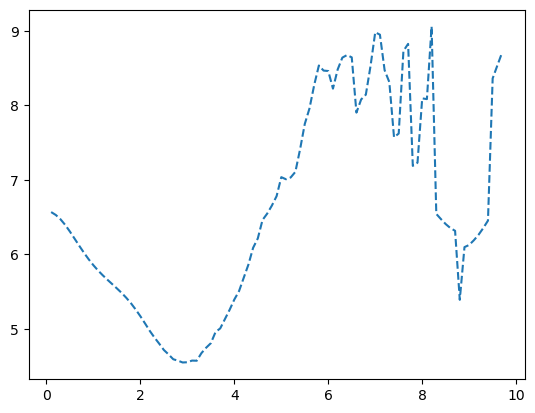

In [1205]:
import matplotlib.pyplot as plt
plot_overall_avgs = all_dist_dfs.query("time_after_snap > 0").groupby(by = ['time_after_snap']).mean().reset_index()

plt.title = "Average Rusher Distance From QB by Seconds After Snap"
plt.xlabel = "Seconds After Snap"
plt.plot('time_after_snap',  'rusher_distance_from_qb', data = plot_overall_avgs, linestyle='dashed')
plt.ylabel = "Rusher Distance From QB"
plt.show()

In [ ]:
### want to get groups of players with similar starting positions: conlusion: just use number of blockers on play for now, maybe add in weigt of blocker later

# this_week_starting_pos = all_data.training_data_individual.get('1')
# this_week_starting_pos = this_week_training_individual.loc[this_week_training_individual.time_after_snap == 0, ['playId', 'nflId', 'rusher_distance_from_qb', 'y']]



# gmm_train = this_week_starting_pos.drop(['playId', 'nflId'], axis = 1)
# gmm = mixture.GaussianMixture(n_components=2).fit(gmm_train)
# gmm_labels = gmm.predict(gmm_train).astype(str)

# this_week_starting_pos['starting_pos_class'] = gmm_labels
# this_week_starting_pos.groupby('starting_pos_class').groups.items()
# plot_df = this_week_starting_pos.drop(['playId', 'nflId'], axis = 1).reset_index(drop = 1)
# plot_df.starting_pos_class.unique()
# plot_df

# groups = plot_df.groupby('starting_pos_class')
# # Plot
# fig, ax = plt.subplots()
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# for name, group in groups:
#     ax.plot(group.rusher_distance_from_qb, group.y, marker='o', linestyle='', ms=12, label=name)
# ax.legend()

# plt.show()

# ret_df = this_week_starting_pos.loc[:, ['playId', 'nflId', 'starting_pos_class']]
# ret_df